# PCA Analysis with clustering


In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import pandas as pd
from kneed import KneeLocator
from functions.data_functions import load_data, connect_to_database
import warnings
warnings.filterwarnings(action='ignore')
from scipy import stats
import re

In [2]:
def nn(data: pd.DataFrame, shape: int, np_round: bool=True) -> pd.DataFrame:

    '''
    Function to do nearest neighbour imputation to get missing values.

    Parameters
    ----------
    data: pd.Dataframe containing missing values
    shape: int n_nighbours parameter on KMNImputer from sckit-learn
    np_round: Bool of if the missing values should be rounded.

    Returns
    -------
    df: pd.Dataframe of results.

    '''
    
    sel_cols = [column for column, is_type in (data.dtypes=="object").items() if is_type]
    value_for_x = data.drop(sel_cols, axis=1).values
    imputer = KNNImputer(n_neighbors=shape, weights="uniform")
    transformed = imputer.fit_transform(value_for_x)

    if np_round == True:
        df = pd.DataFrame(np.round(transformed), columns=data.drop(sel_cols, axis=1).columns)
    else:
        df = pd.DataFrame(transformed, columns=data.drop(sel_cols, axis=1).columns)

    for col in sel_cols:
        df[col] = data[col].reset_index(drop=True)

    return df

In [17]:
def imputate(data: pd.DataFrame, col: str,  indicator: str, np_round: bool=True) -> pd.DataFrame:

    '''
    Function to imputate data based on group. Also adds in group column

    Parameters
    ----------
    data: pd.DataFrame of data.
    np_round: Bool to round the imputated value to nearest whole value

    Returns
    -------
    pd.DataFrame with imputated values.
    '''

    try: 
        hc = data[data[col].str.contains(f'{indicator}1', regex=True)]
        an = data[data[col].str.contains(f'{indicator}2', regex=True)]

        if hc.isnull().values.any() == True:
            print(f'Null values detected in the HC data for {data.columns[0]}. Imputating data')
            hc_data = nn(hc, hc.shape[1], np_round)

        else:
            hc_data = hc
            

        if an.isnull().values.any() == True:
            print(f'Null values detected in the AN data for {data.columns[0]}. Imputating data')
            an_data = nn(an, an.shape[1], np_round)

        else:
            an_data = an

    except Exception as e:
        print(f'Unable to imputate due to {e}')
        sys.exit(1)

    return pd.concat([hc_data, an_data], axis=0).reset_index(drop=True)

Load the data

In [7]:
t1_df = load_data('BEACON', 't1_measures')
#t2_df = load_data('BEACON', 't2_measures')
#participant_index = load_data('BEACON', 'participant_index')

ProgrammingError: (mysql.connector.errors.ProgrammingError) 1045 (28000): Access denied for user 'wmda'@'10.0.0.9' (using password: YES)
(Background on this error at: https://sqlalche.me/e/14/f405)

reorder t1 database based on order of time point 2. 

In [6]:
t1_df = pd.merge(participant_index['t1'], t1_df, left_on='t1', right_on='G_Number', how='left').drop(['t1', 'index'], axis=1)
t1_df

,G_Number,aq_score_t1,anxiety_t1,depression_t1,bmi_t1,oci_score_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1,global_score_t1,group
0,G1038,2.0,4.0,2.0,22.038567,1.0,0.0,0.0,0.0,0.375,0.2,0.14000,HC_t1
1,G1010,2.0,1.0,0.0,22.718974,3.0,1.0,0.0,0.0,0.375,0.2,0.14000,HC_t1
2,G1014,2.0,3.0,2.0,23.722811,0.0,0.0,0.0,0.0,0.875,0.0,0.22000,HC_t1
3,G1056,NaN,NaN,NaN,20.614236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HC_t1
4,G1023,2.0,8.0,4.0,23.612751,19.0,0.0,0.2,0.2,3.125,3.4,1.73000,HC_t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,G2141,4.0,12.0,7.0,16.757637,16.0,27.0,4.6,3.2,5.625,4.2,4.40625,AN_t1
130,G2138,0.0,8.0,3.0,16.602388,4.0,16.0,0.0,0.2,3.250,1.2,1.16250,AN_t1
131,G2140,2.0,8.0,7.0,14.933853,9.0,32.0,5.0,4.6,6.000,4.8,5.10000,AN_t1
132,G2105,2.0,10.0,8.0,18.630735,43.0,27.0,4.6,3.2,4.875,3.2,3.97000,AN_t1


In [7]:
t2_df

,index,B_Number,aq_score_t2,anxiety_t2,depression_t2,bmi_t2,oci_score_t2,wsas_score_t2,restraint,eating_concern,shape_concern,weight_concern,global_score_t2,group
0,0,B1002,0.0,6.0,1.0,33.017818,4.0,0.0,1.8,0.2,1.625,1.6,1.30625,HC
1,1,B1003,1.0,4.0,2.0,22.832879,1.0,0.0,0.0,0.0,0.000,0.0,0.00000,HC
2,2,B1004,3.0,9.0,3.0,24.683905,27.0,2.0,1.2,0.8,2.250,0.4,1.16250,HC
3,3,B1006,6.0,11.0,3.0,21.218317,10.0,7.0,1.2,0.8,1.500,1.0,1.12500,HC
4,4,B1007,2.0,6.0,7.0,24.034407,11.0,0.0,2.2,0.4,2.750,2.0,1.83750,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,129,B2091,5.0,14.0,11.0,15.084373,24.0,24.0,2.4,1.6,4.750,2.0,2.68750,AN
130,130,B2092,2.0,13.0,5.0,19.467401,15.0,16.0,1.4,2.0,3.250,1.6,2.06250,AN
131,131,B2093,1.0,11.0,16.0,14.733633,9.0,29.0,6.0,4.6,5.750,4.8,5.28750,AN
132,132,B2094,1.0,15.0,7.0,18.365473,53.0,34.0,5.0,5.6,5.875,4.4,5.21875,AN


Imputate any missing values that were not done in the initial stages of pre-processing

In [20]:
not_to_round = ['bmi_t1','bmi_t2' ,'restraint', 'restraint_score_t1', 'eating_concern', 'eating_concern_score_t1',
                'shape_concern', 'shape_concern_score_t1', 'weight_concern','weight_concern_score_t1' ,'global_score',
                 'global_score_t1']

In [21]:
imputated_df_t1 = pd.DataFrame()
imputated_df_t1['G_Number'] = t1_df['G_Number']
for col in t1_df.columns:
    if col != 'G_Number' and col !='group':
        if col in not_to_round:
            imputated_values = imputate(t1_df[[col, 'G_Number']], col='G_Number', indicator='G', np_round='False')
        else:
            imputated_values = imputate(t1_df[[col, 'G_Number']], col='G_Number', indicator='G')
        imputated_df_t1 = pd.merge(imputated_df_t1, imputated_values, on='G_Number' )

Null values detected in the HC data for aq_score_t1. Imputating data
Null values detected in the AN data for aq_score_t1. Imputating data
Null values detected in the HC data for anxiety_t1. Imputating data
Null values detected in the AN data for anxiety_t1. Imputating data
Null values detected in the HC data for depression_t1. Imputating data
Null values detected in the AN data for depression_t1. Imputating data
Null values detected in the HC data for bmi_t1. Imputating data
Null values detected in the HC data for oci_score_t1. Imputating data
Null values detected in the AN data for oci_score_t1. Imputating data
Null values detected in the HC data for wsas_score_t1. Imputating data
Null values detected in the AN data for wsas_score_t1. Imputating data
Null values detected in the HC data for restraint_score_t1. Imputating data
Null values detected in the AN data for restraint_score_t1. Imputating data
Null values detected in the HC data for eating_concern_score_t1. Imputating data
Null 

In [22]:
imputated_df_t2 = pd.DataFrame()
imputated_df_t2['B_Number'] = t2_df['B_Number']
for col in t2_df.columns:
    if col != 'B_Number' and col !='group':
        if  col in not_to_round:
            imputated_values = imputate(t2_df[[col, 'B_Number']], col='B_Number', indicator='B', np_round='False')
        else:
            imputated_values = imputate(t2_df[[col, 'B_Number']], col='B_Number', indicator='B')
        imputated_df_t2 = pd.merge(imputated_df_t2, imputated_values, on='B_Number' )

Null values detected in the AN data for aq_score_t2. Imputating data
Null values detected in the AN data for anxiety_t2. Imputating data
Null values detected in the AN data for depression_t2. Imputating data
not rounding bmi_t2
Null values detected in the HC data for bmi_t2. Imputating data
Null values detected in the AN data for bmi_t2. Imputating data
Null values detected in the AN data for oci_score_t2. Imputating data
Null values detected in the AN data for wsas_score_t2. Imputating data
not rounding restraint
Null values detected in the AN data for restraint. Imputating data
not rounding eating_concern
Null values detected in the AN data for eating_concern. Imputating data
not rounding shape_concern
Null values detected in the AN data for shape_concern. Imputating data
not rounding weight_concern
Null values detected in the AN data for weight_concern. Imputating data
Null values detected in the AN data for global_score_t2. Imputating data


In [25]:
pca_df = pd.concat([imputated_df_t1, imputated_df_t2], axis=1).rename(columns={'restraint':'restraint_score_t2', 'eating_concern':'eating_concern_score_t2', 
                                                           'shape_concern': 'shape_concern_score_t2', 'weight_concern': 'weight_concern_score_t2' })
pca_df

,G_Number,aq_score_t1,anxiety_t1,depression_t1,bmi_t1,oci_score_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,...,anxiety_t2,depression_t2,bmi_t2,oci_score_t2,wsas_score_t2,restraint_score_t2,eating_concern_score_t2,shape_concern_score_t2,weight_concern_score_t2,global_score_t2
0,G1038,2.0,4.0,2.0,22.038567,1.0,0.0,0.000000,0.000000,0.375000,...,6.0,1.0,33.017818,4.0,0.0,1.8,0.2,1.625,1.6,1.30625
1,G1010,2.0,1.0,0.0,22.718974,3.0,1.0,0.000000,0.000000,0.375000,...,4.0,2.0,22.832879,1.0,0.0,0.0,0.0,0.000,0.0,0.00000
2,G1014,2.0,3.0,2.0,23.722811,0.0,0.0,0.000000,0.000000,0.875000,...,9.0,3.0,24.683905,27.0,2.0,1.2,0.8,2.250,0.4,1.16250
3,G1056,2.0,5.0,3.0,20.614236,8.0,3.0,0.594595,0.313514,1.192568,...,11.0,3.0,21.218317,10.0,7.0,1.2,0.8,1.500,1.0,1.12500
4,G1023,2.0,8.0,4.0,23.612751,19.0,0.0,0.200000,0.200000,3.125000,...,6.0,7.0,24.034407,11.0,0.0,2.2,0.4,2.750,2.0,1.83750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,G2141,4.0,12.0,7.0,16.757637,16.0,27.0,4.600000,3.200000,5.625000,...,14.0,11.0,15.084373,24.0,24.0,2.4,1.6,4.750,2.0,3.00000
130,G2138,0.0,8.0,3.0,16.602388,4.0,16.0,0.000000,0.200000,3.250000,...,13.0,5.0,19.467401,15.0,16.0,1.4,2.0,3.250,1.6,2.00000
131,G2140,2.0,8.0,7.0,14.933853,9.0,32.0,5.000000,4.600000,6.000000,...,11.0,16.0,14.733633,9.0,29.0,6.0,4.6,5.750,4.8,5.00000
132,G2105,2.0,10.0,8.0,18.630735,43.0,27.0,4.600000,3.200000,4.875000,...,15.0,7.0,18.365473,53.0,34.0,5.0,5.6,5.875,4.4,5.00000


In [29]:
hc = pca_df[pca_df['B_Number'].str.contains('B1')]
an = pca_df[pca_df['B_Number'].str.contains('B2')]

hc['group'] = 'HC'
an['group'] = 'AN'

pca_df = pd.concat([hc, an])

In [30]:
print(pca_df[pca_df['B_Number'].str.contains('B1')].shape)
print(pca_df[pca_df['B_Number'].str.contains('B2')].shape)

(40, 26)
(94, 26)


## Preprocessing

Due to the data being in different units this can cause some measures to be weighted more in the segmentation model compared with others. For example a difference in the ede-q between HC participants could be 0.5 however there could be a difference of 10 between the lowest and highest BMI.

To prevent this all the data is standardized by removing the mean and scaling to unit variance.

```z = (x - u) / s```

Where u is the mean and s is the standard variaces. 

In [31]:
t1_pca = pca_df[['aq_score_t1','anxiety_t1', 'depression_t1', 'oci_score_t1', 'bmi_t1', 'wsas_score_t1', 'restraint_score_t1', 'eating_concern_score_t1', 'shape_concern_score_t1', 'weight_concern_score_t1']]
t2_pca = pca_df[['aq_score_t2','anxiety_t2', 'depression_t2', 'oci_score_t2' ,'bmi_t2', 'wsas_score_t2', 'restraint_score_t2', 'eating_concern_score_t2', 'shape_concern_score_t2', 'weight_concern_score_t2']]

In [32]:
t1_pca

,aq_score_t1,anxiety_t1,depression_t1,oci_score_t1,bmi_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1
0,2.0,4.0,2.0,1.0,22.038567,0.0,0.000000,0.000000,0.375000,0.200000
1,2.0,1.0,0.0,3.0,22.718974,1.0,0.000000,0.000000,0.375000,0.200000
2,2.0,3.0,2.0,0.0,23.722811,0.0,0.000000,0.000000,0.875000,0.000000
3,2.0,5.0,3.0,8.0,20.614236,3.0,0.594595,0.313514,1.192568,0.994595
4,2.0,8.0,4.0,19.0,23.612751,0.0,0.200000,0.200000,3.125000,3.400000
...,...,...,...,...,...,...,...,...,...,...
129,4.0,12.0,7.0,16.0,16.757637,27.0,4.600000,3.200000,5.625000,4.200000
130,0.0,8.0,3.0,4.0,16.602388,16.0,0.000000,0.200000,3.250000,1.200000
131,2.0,8.0,7.0,9.0,14.933853,32.0,5.000000,4.600000,6.000000,4.800000
132,2.0,10.0,8.0,43.0,18.630735,27.0,4.600000,3.200000,4.875000,3.200000


In [33]:
scaler = StandardScaler()
t1_scaler = scaler.fit_transform(t1_pca)
t2_scaler = scaler.fit_transform(t2_pca)

## Dimensionality Reduction

In [34]:
t1_pca_model = PCA()
t1_pca_model.fit(t1_scaler)
t1_pca_scores = t1_pca_model.transform(t1_scaler)

t1_wcss = []

for cluster_number in range(1,21):
    kmeans_pca = KMeans(n_clusters=cluster_number, random_state=42)
    kmeans_pca.fit(t1_pca_scores)
    t1_wcss.append(kmeans_pca.inertia_)

t1_kl = KneeLocator(range(1, 21), t1_wcss, curve="convex", direction="decreasing")
print(t1_kl.elbow)

3


Text(0, 0.5, 'Cumulative Explained variance')

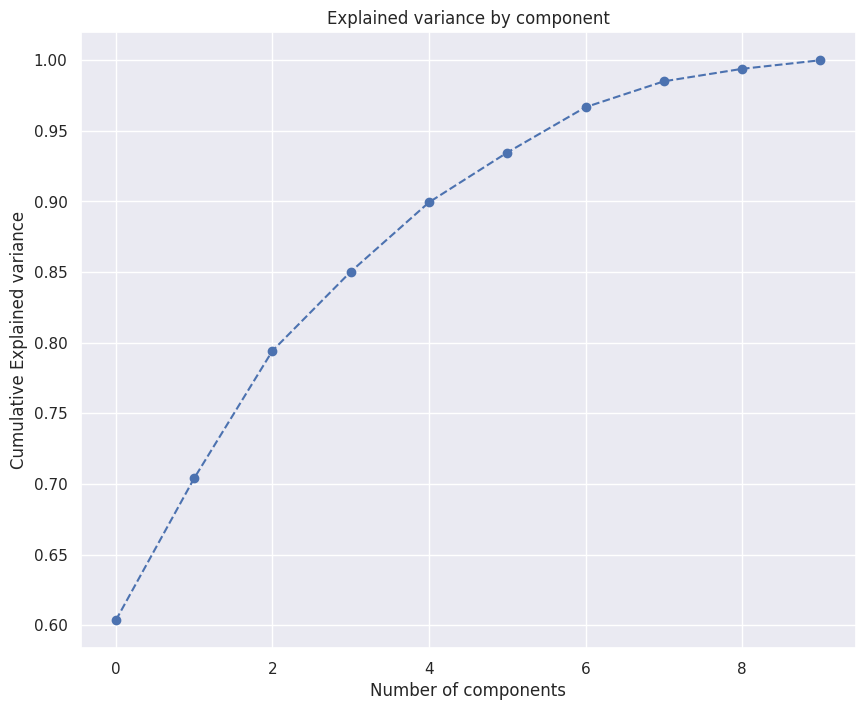

In [35]:
plt.figure(figsize=(10,8))
plt.plot(t1_pca_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--' )
plt.title('Explained variance by component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

Text(0, 0.5, 'WCSS')

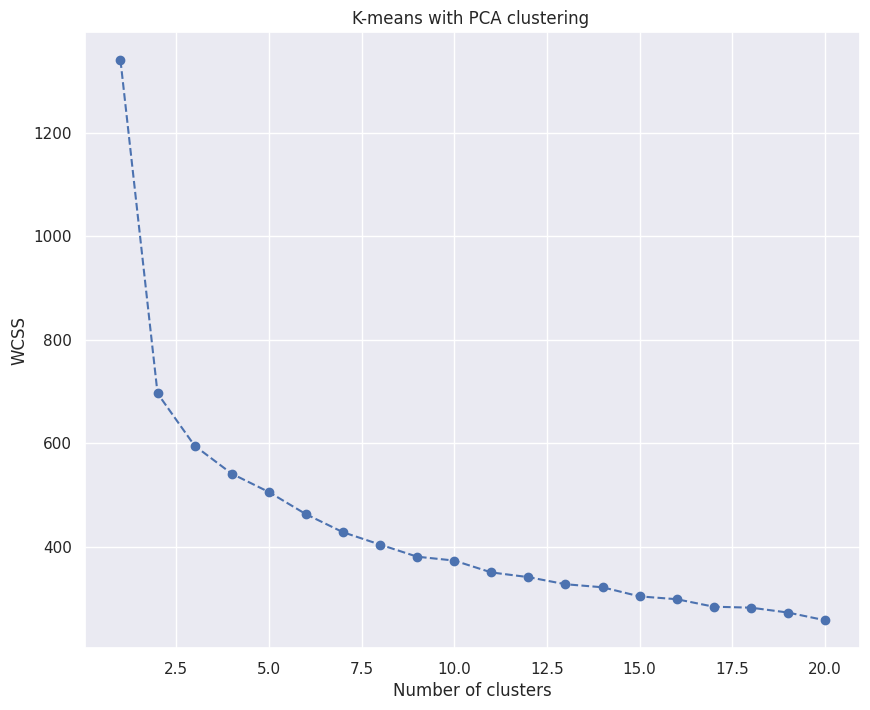

In [36]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21), t1_wcss, marker='o', linestyle='--')
plt.title('K-means with PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [37]:
t2_pca_model = PCA()
t2_pca_model.fit(t2_scaler)
t2_pca_scores = t2_pca_model.transform(t2_scaler)

t2_wcss = []

for cluster_number in range(1,21):
    t2_kmeans_pca = KMeans(n_clusters=cluster_number, random_state=42)
    t2_kmeans_pca.fit(t1_pca_scores)
    t2_wcss.append(t2_kmeans_pca.inertia_)

t2_kl = KneeLocator(range(1, 21), t2_wcss, curve="convex", direction="decreasing")
print(t2_kl.elbow)

3


Text(0, 0.5, 'Cumulative Explained variance')

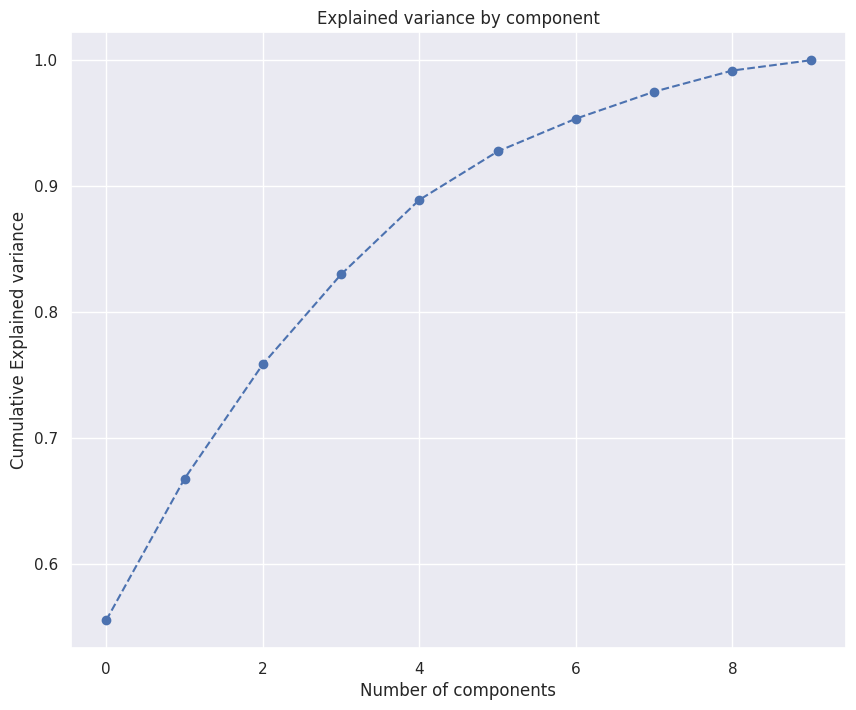

In [38]:
plt.figure(figsize=(10,8))
plt.plot(t2_pca_model.explained_variance_ratio_.cumsum(), marker='o', linestyle='--' )
plt.title('Explained variance by component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

Text(0, 0.5, 'WCSS')

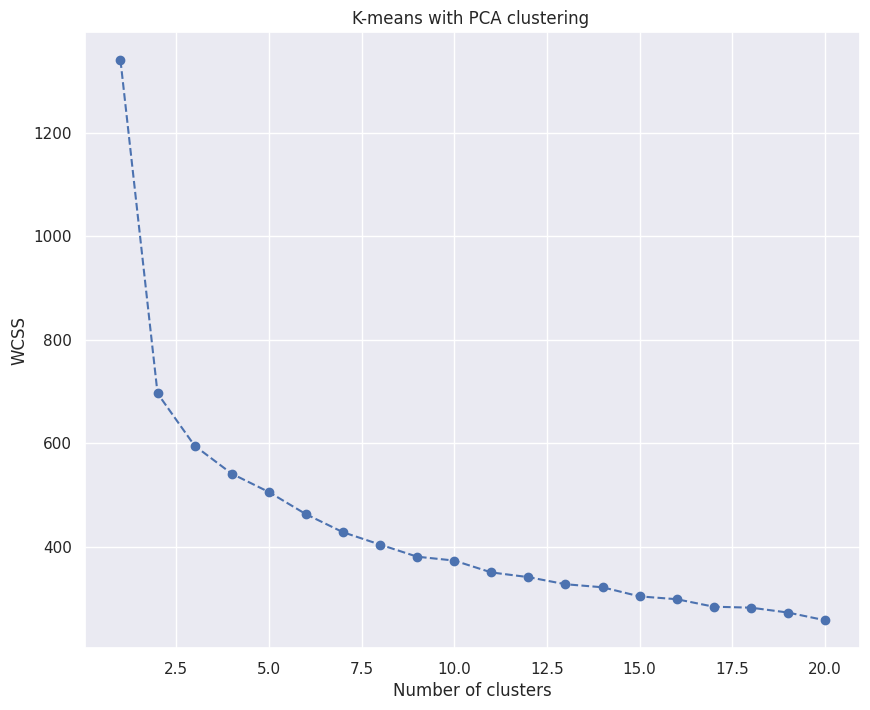

In [39]:
plt.figure(figsize=(10,8))
plt.plot(range(1,21), t2_wcss, marker='o', linestyle='--')
plt.title('K-means with PCA clustering ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [40]:
print('t1 explained variance ratio:\n', t1_pca_model.explained_variance_ratio_)
print('\nt2 explained variance ratio:\n', t2_pca_model.explained_variance_ratio_)

t1 explained variance ratio:
 [0.60345503 0.10050487 0.09028714 0.05601165 0.04912617 0.0352787
 0.03211039 0.01830882 0.0088387  0.00607852]

t2 explained variance ratio:
 [0.55513026 0.11240685 0.09093206 0.07140816 0.05922535 0.03844154
 0.0260484  0.02144689 0.01679695 0.00816355]


## Dataframes

In [44]:
t1_pca_group = pd.concat([pca_df['G_Number'], t1_pca], axis=1)
t1_df_seg = pd.concat([t1_pca_group, pd.DataFrame(t1_pca_scores)], axis=1)
t1_df_seg.columns.values[11:14] = ['comp_1', 'comp_2', 'comp_3']
t1_df_seg = t1_df_seg.drop([3 , 4, 5, 6, 7, 8,9,], axis=1)
t1_df_seg

,G_Number,aq_score_t1,anxiety_t1,depression_t1,oci_score_t1,bmi_t1,wsas_score_t1,restraint_score_t1,eating_concern_score_t1,shape_concern_score_t1,weight_concern_score_t1,comp_1,comp_2,comp_3
0,G1038,2.0,4.0,2.0,1.0,22.038567,0.0,0.000000,0.000000,0.375000,0.200000,-3.397712,-0.039728,0.044067
1,G1010,2.0,1.0,0.0,3.0,22.718974,1.0,0.000000,0.000000,0.375000,0.200000,-3.759757,-0.312506,0.406467
2,G1014,2.0,3.0,2.0,0.0,23.722811,0.0,0.000000,0.000000,0.875000,0.000000,-3.532270,-0.211892,0.493511
3,G1056,2.0,5.0,3.0,8.0,20.614236,3.0,0.594595,0.313514,1.192568,0.994595,-2.459692,-0.062705,-0.095992
4,G1023,2.0,8.0,4.0,19.0,23.612751,0.0,0.200000,0.200000,3.125000,3.400000,-1.476319,-0.129427,1.175674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,G2141,4.0,12.0,7.0,16.0,16.757637,27.0,4.600000,3.200000,5.625000,4.200000,2.462581,-0.667664,-0.436650
130,G2138,0.0,8.0,3.0,4.0,16.602388,16.0,0.000000,0.200000,3.250000,1.200000,-1.634660,-0.686854,-1.347601
131,G2140,2.0,8.0,7.0,9.0,14.933853,32.0,5.000000,4.600000,6.000000,4.800000,2.637032,-2.079384,-1.025924
132,G2105,2.0,10.0,8.0,43.0,18.630735,27.0,4.600000,3.200000,4.875000,3.200000,2.295672,-0.339904,0.279827


<AxesSubplot: xlabel='comp_1', ylabel='comp_2'>

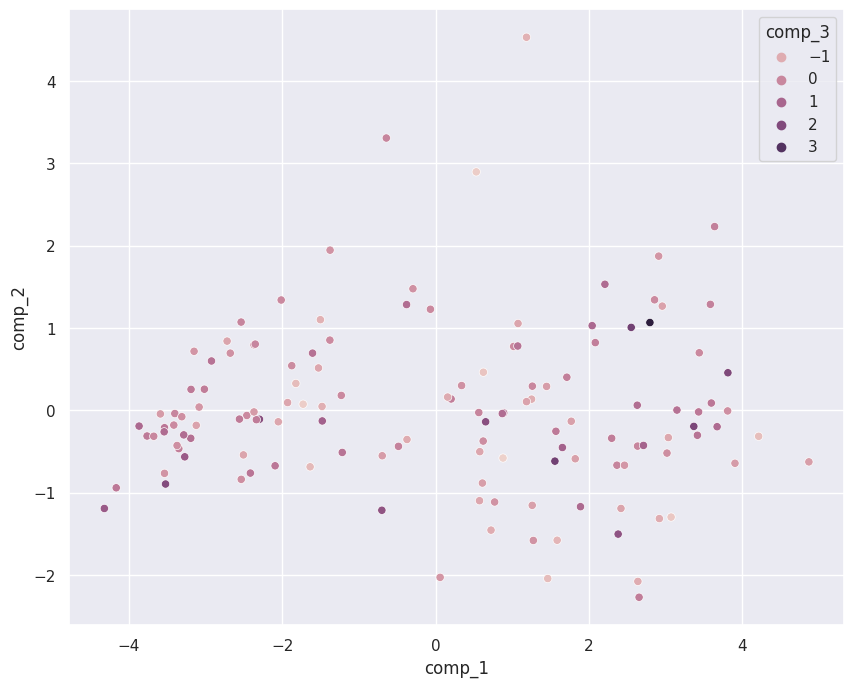

In [45]:
plt.figure(figsize=(10,8))
sns.scatterplot('comp_1', 'comp_2', 'comp_3', data=t1_df_seg, hue='segment')

In [47]:
t2_pca_group = pd.concat([pca_df['B_Number'], t2_pca], axis=1)
t2_df_seg = pd.concat([t2_pca_group, pd.DataFrame(t2_pca_scores)], axis=1)
t2_df_seg.columns.values[11:14] = ['comp_1', 'comp_2', 'comp_3']
t2_df_seg = t2_df_seg.drop([3, 4, 5, 6, 7, 8, 9], axis=1)
t2_df_seg

,B_Number,aq_score_t2,anxiety_t2,depression_t2,oci_score_t2,bmi_t2,wsas_score_t2,restraint_score_t2,eating_concern_score_t2,shape_concern_score_t2,weight_concern_score_t2,comp_1,comp_2,comp_3
0,B1002,0.0,6.0,1.0,4.0,33.017818,0.0,1.8,0.2,1.625,1.6,-2.751847,-1.763316,2.199746
1,B1003,1.0,4.0,2.0,1.0,22.832879,0.0,0.0,0.0,0.000,0.0,-3.441539,-0.316748,-0.210088
2,B1004,3.0,9.0,3.0,27.0,24.683905,2.0,1.2,0.8,2.250,0.4,-1.389329,0.311159,0.983941
3,B1006,6.0,11.0,3.0,10.0,21.218317,7.0,1.2,0.8,1.500,1.0,-1.050591,1.116984,0.019420
4,B1007,2.0,6.0,7.0,11.0,24.034407,0.0,2.2,0.4,2.750,2.0,-1.181176,-0.783917,0.744101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,B2091,5.0,14.0,11.0,24.0,15.084373,24.0,2.4,1.6,4.750,2.0,2.025310,1.042486,-0.784687
130,B2092,2.0,13.0,5.0,15.0,19.467401,16.0,1.4,2.0,3.250,1.6,0.157375,-0.139806,-0.360662
131,B2093,1.0,11.0,16.0,9.0,14.733633,29.0,6.0,4.6,5.750,4.8,3.998414,-2.064403,-1.245633
132,B2094,1.0,15.0,7.0,53.0,18.365473,34.0,5.0,5.6,5.875,4.4,4.474773,-1.406758,0.090732


<AxesSubplot: xlabel='comp_1', ylabel='comp_2'>

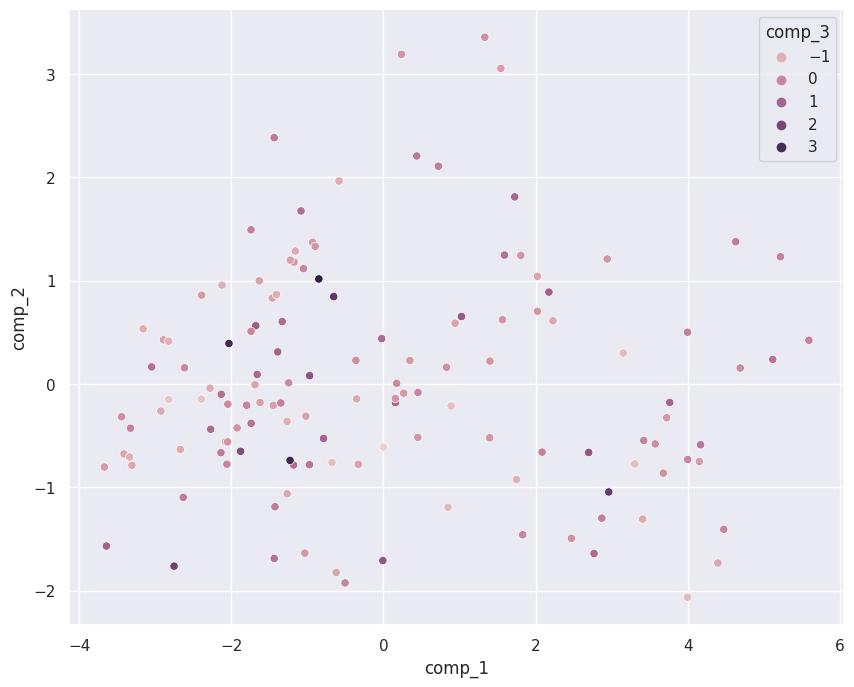

In [48]:
plt.figure(figsize=(10,8))
sns.scatterplot('comp_1', 'comp_2', 'comp_3', data=t2_df_seg, hue='segment')

## Examine the relationship between components and measures

In [49]:
measures_t1 = ['oci_score_t1', 'bmi_t1', 'anxiety_t1', 'depression_t1', 'restraint_score_t1', 'eating_concern_score_t1', 'shape_concern_score_t1', 'weight_concern_score_t1', 'aq_score_t1', 'wsas_score_t1']

correlations_t1 = {
    'comp_1': {},
    'comp_2': {},
    'comp_3': {},
}

for component in correlations_t1.keys():
    for measure in measures_t1:
        correlations_t1[component][measure] =  stats.pearsonr(t1_df_seg[component], t1_df_seg[measure])[0]

measures_t2 = ['oci_score_t2', 'bmi_t2', 'anxiety_t2', 'depression_t2', 'restraint_score_t2', 'eating_concern_score_t2', 'shape_concern_score_t2', 'weight_concern_score_t2', 'aq_score_t2', 'wsas_score_t2']

correlations_t2 = {
    'comp_1': {},
    'comp_2': {},
    'comp_3': {},
}

for component in correlations_t2.keys():
    for measure in measures_t2:
        correlations_t2[component][measure] =  stats.pearsonr(t2_df_seg[component], t2_df_seg[measure])[0]


{'oci_score_t1': 0.6556199201865376, 'bmi_t1': -0.4555325331599669, 'anxiety_t1': 0.7866428514078726, 'depression_t1': 0.7801857763725899, 'restraint_score_t1': 0.8832884659326146, 'eating_concern_score_t1': 0.9227815587406115, 'shape_concern_score_t1': 0.903162134461114, 'weight_concern_score_t1': 0.8899355773178392, 'aq_score_t1': 0.5212743335654765, 'wsas_score_t1': 0.8115218106634364}


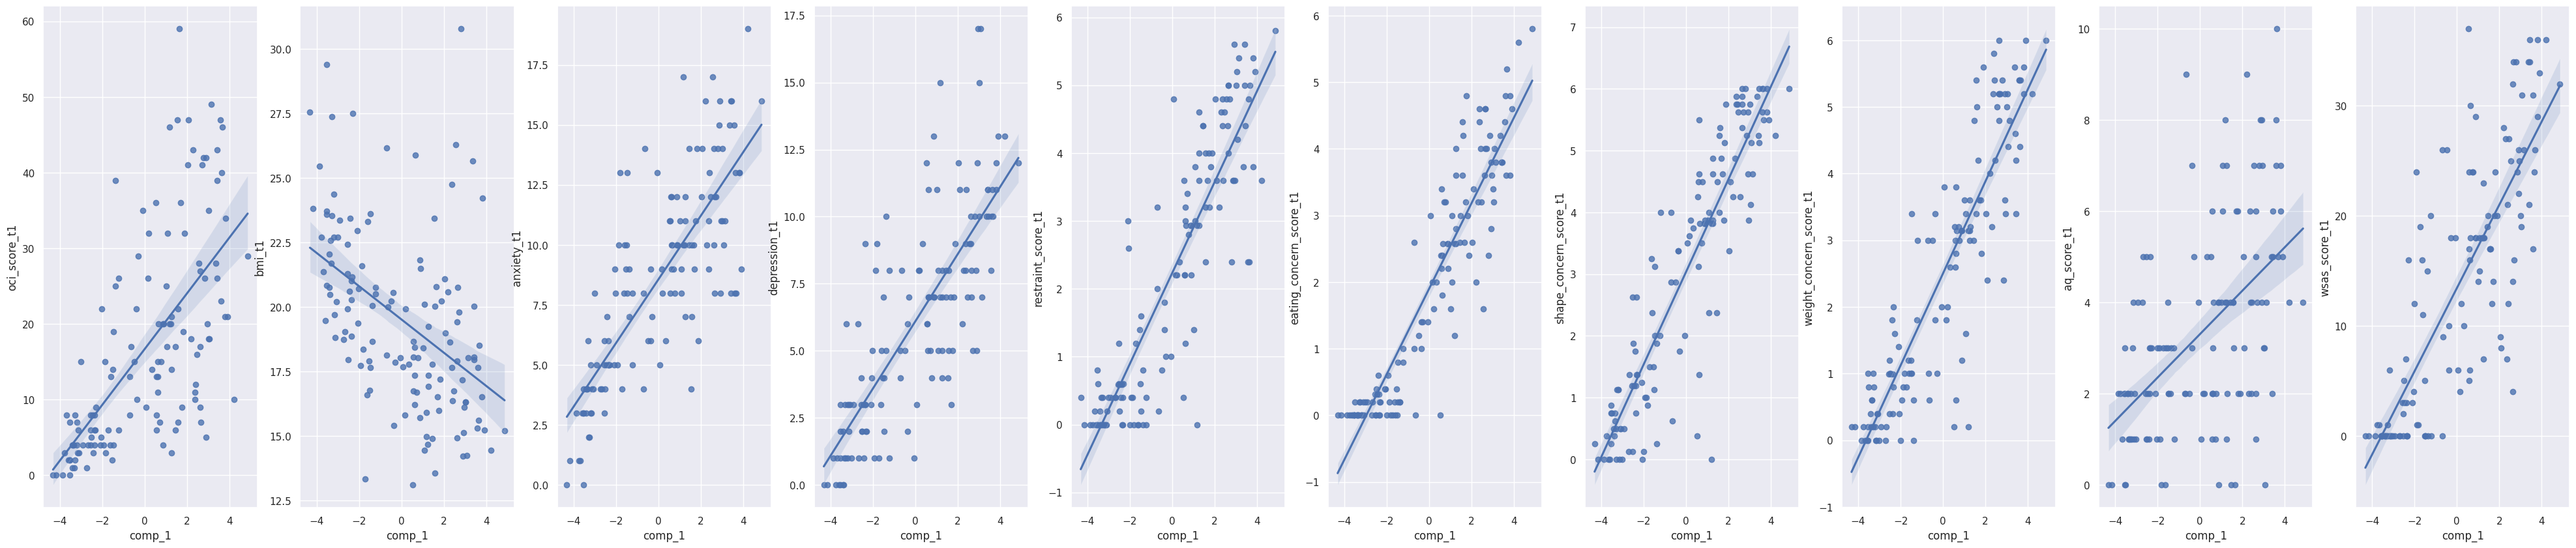

In [50]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_1',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_1'])

{'oci_score_t1': 0.39084110659990906, 'bmi_t1': -0.08548211886312747, 'anxiety_t1': 0.2747070113215238, 'depression_t1': 0.2204459515419931, 'restraint_score_t1': -0.27733848209978695, 'eating_concern_score_t1': -0.25247051502913676, 'shape_concern_score_t1': -0.2773717028133921, 'weight_concern_score_t1': -0.3004061506156654, 'aq_score_t1': 0.6421364663585569, 'wsas_score_t1': -0.02735441493342058}


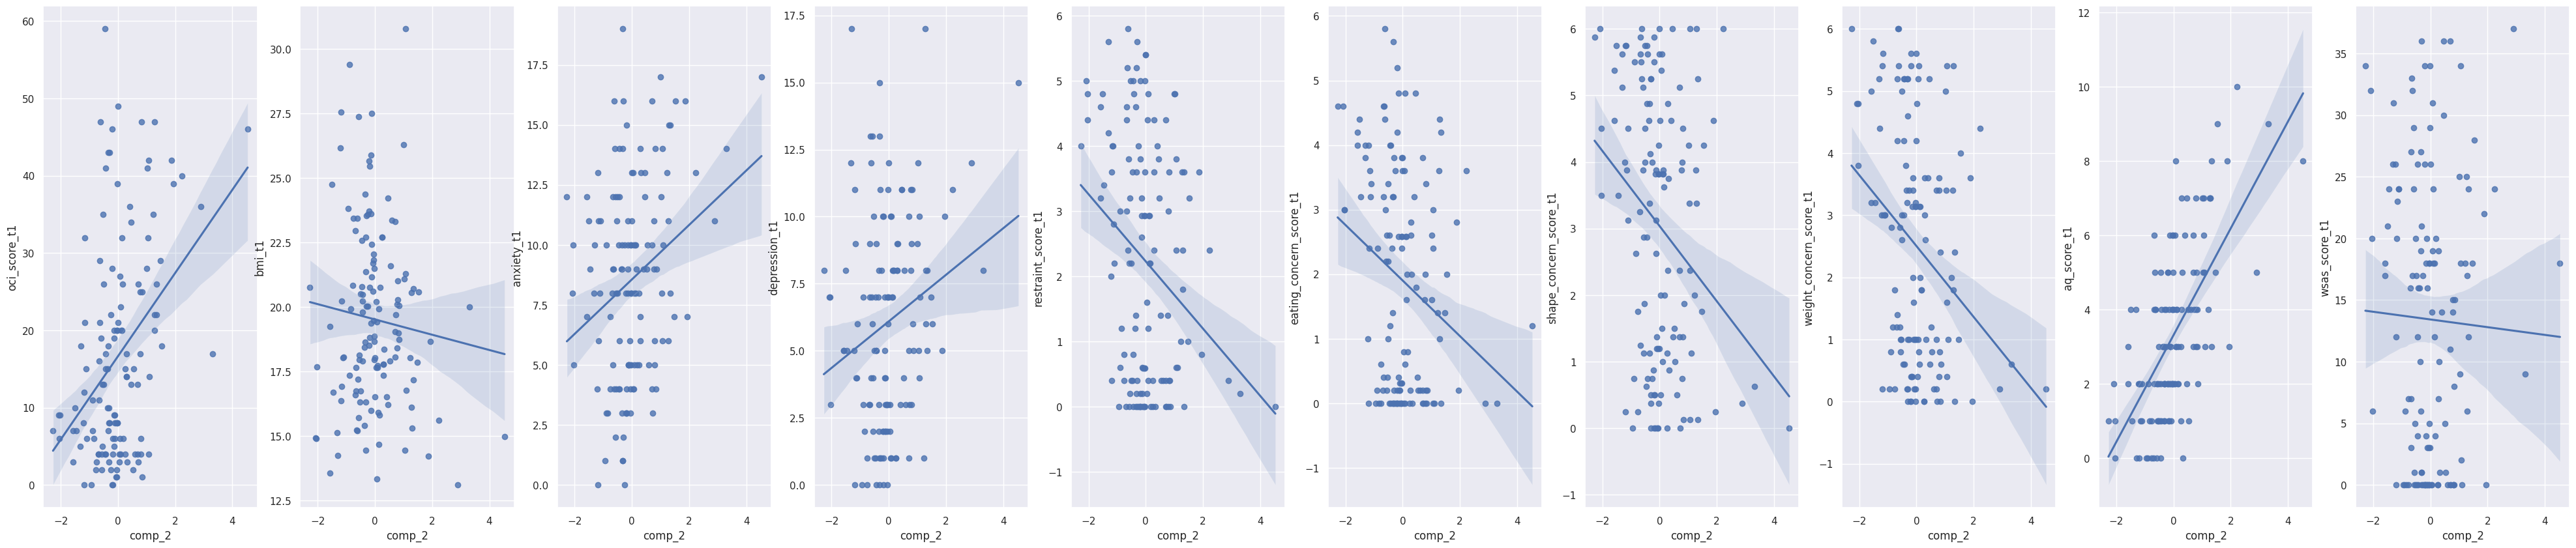

In [51]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_2',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_2'])

{'oci_score_t1': 0.2697237217692438, 'bmi_t1': 0.8412621638692456, 'anxiety_t1': -0.1137248585328408, 'depression_t1': -0.11936261671695989, 'restraint_score_t1': 0.013061513856592613, 'eating_concern_score_t1': 0.005313233292377293, 'shape_concern_score_t1': 0.13055928096220373, 'weight_concern_score_t1': 0.19919568700863824, 'aq_score_t1': 0.1935279626712643, 'wsas_score_t1': -0.02900331559085399}


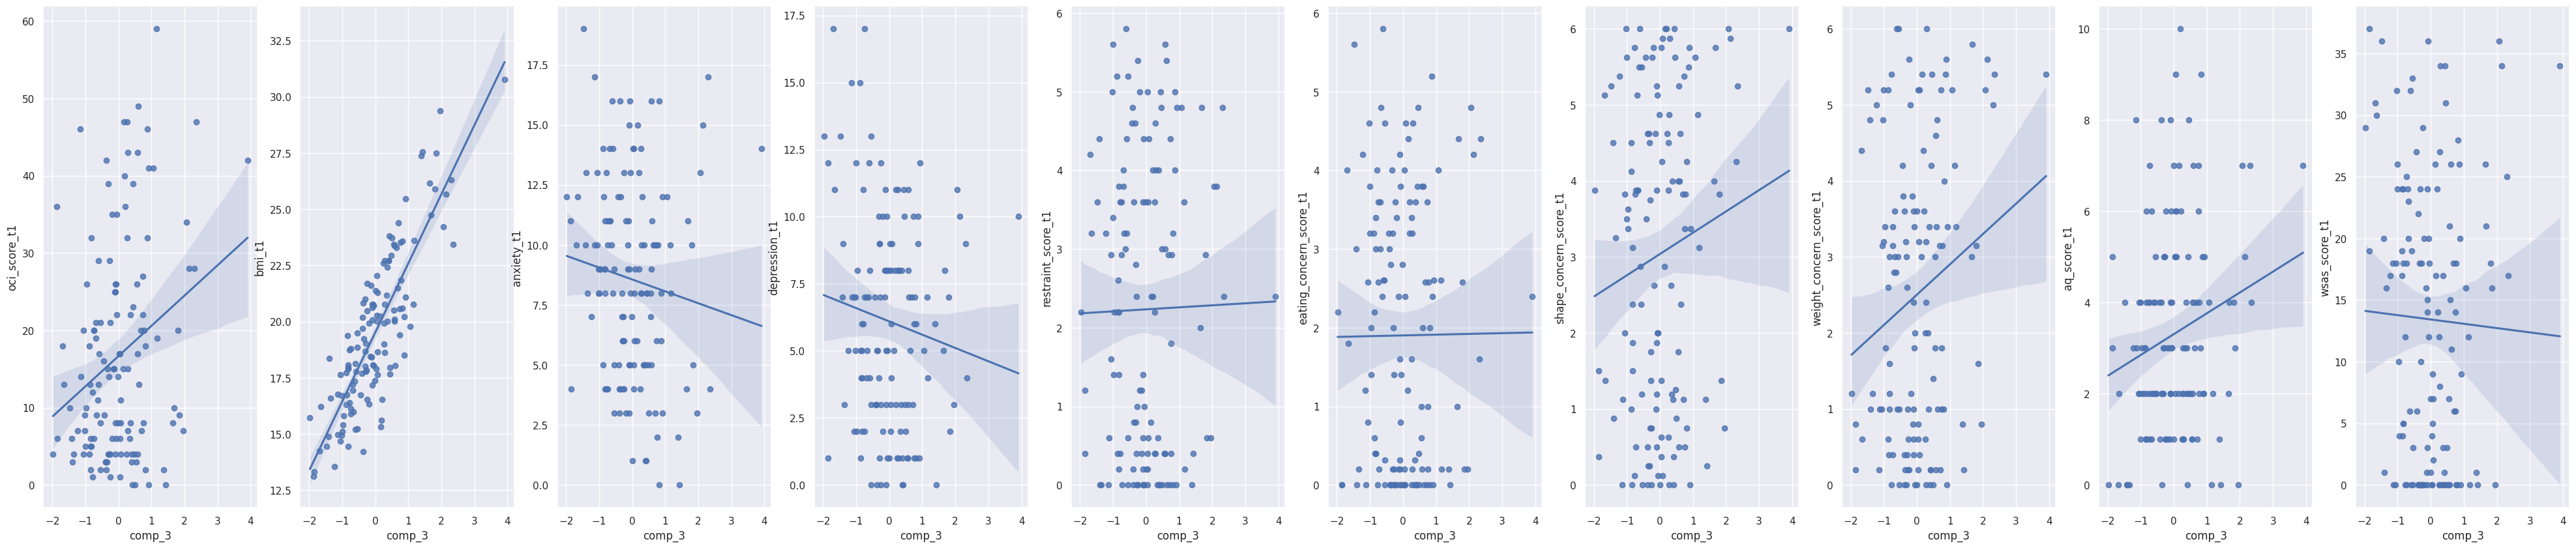

In [52]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t1):
    sns.regplot(y=measure, x='comp_3',data=t1_df_seg, ax=ax[index])
print(correlations_t1['comp_3'])

{'oci_score_t2': 0.6688375336183909, 'bmi_t2': -0.4339120691206839, 'anxiety_t2': 0.7420389650142246, 'depression_t2': 0.7149775464460548, 'restraint_score_t2': 0.8361861618661235, 'eating_concern_score_t2': 0.872166295374013, 'shape_concern_score_t2': 0.8769668402388098, 'weight_concern_score_t2': 0.8642945435399303, 'aq_score_t2': 0.4437323994169143, 'wsas_score_t2': 0.8252326182045028}


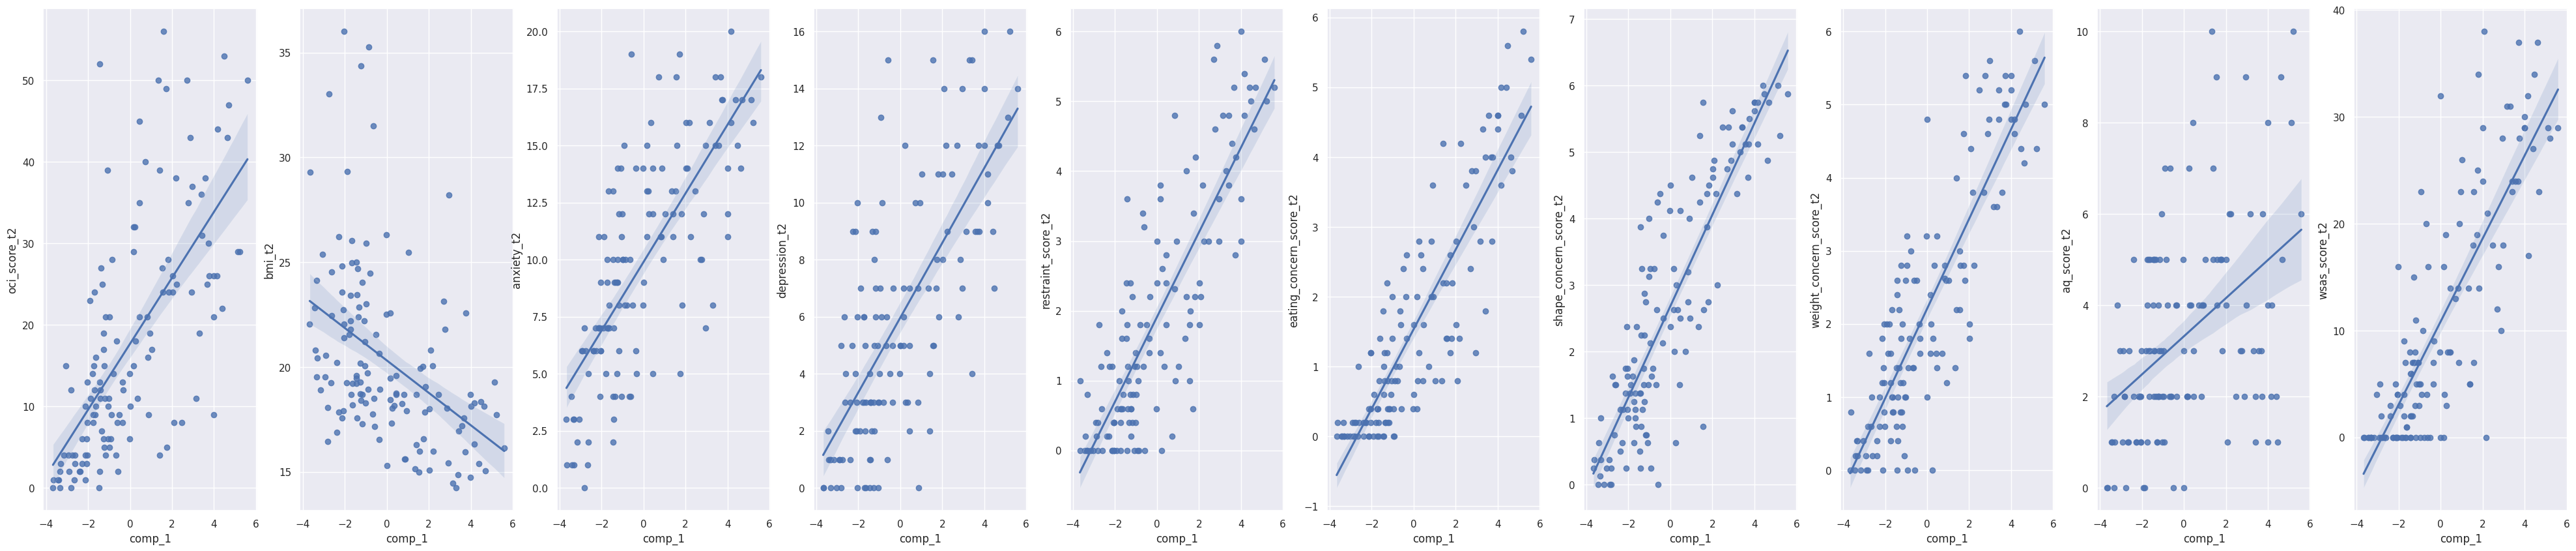

In [53]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_1',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_1'])

{'oci_score_t2': 0.29921361611353126, 'bmi_t2': -0.15998284496962753, 'anxiety_t2': 0.33861951767647325, 'depression_t2': 0.24738940154986763, 'restraint_score_t2': -0.3325961545874038, 'eating_concern_score_t2': -0.23954260394832982, 'shape_concern_score_t2': -0.3196754237107561, 'weight_concern_score_t2': -0.34895714453233684, 'aq_score_t2': 0.6571044262531858, 'wsas_score_t2': 0.0965918409459069}


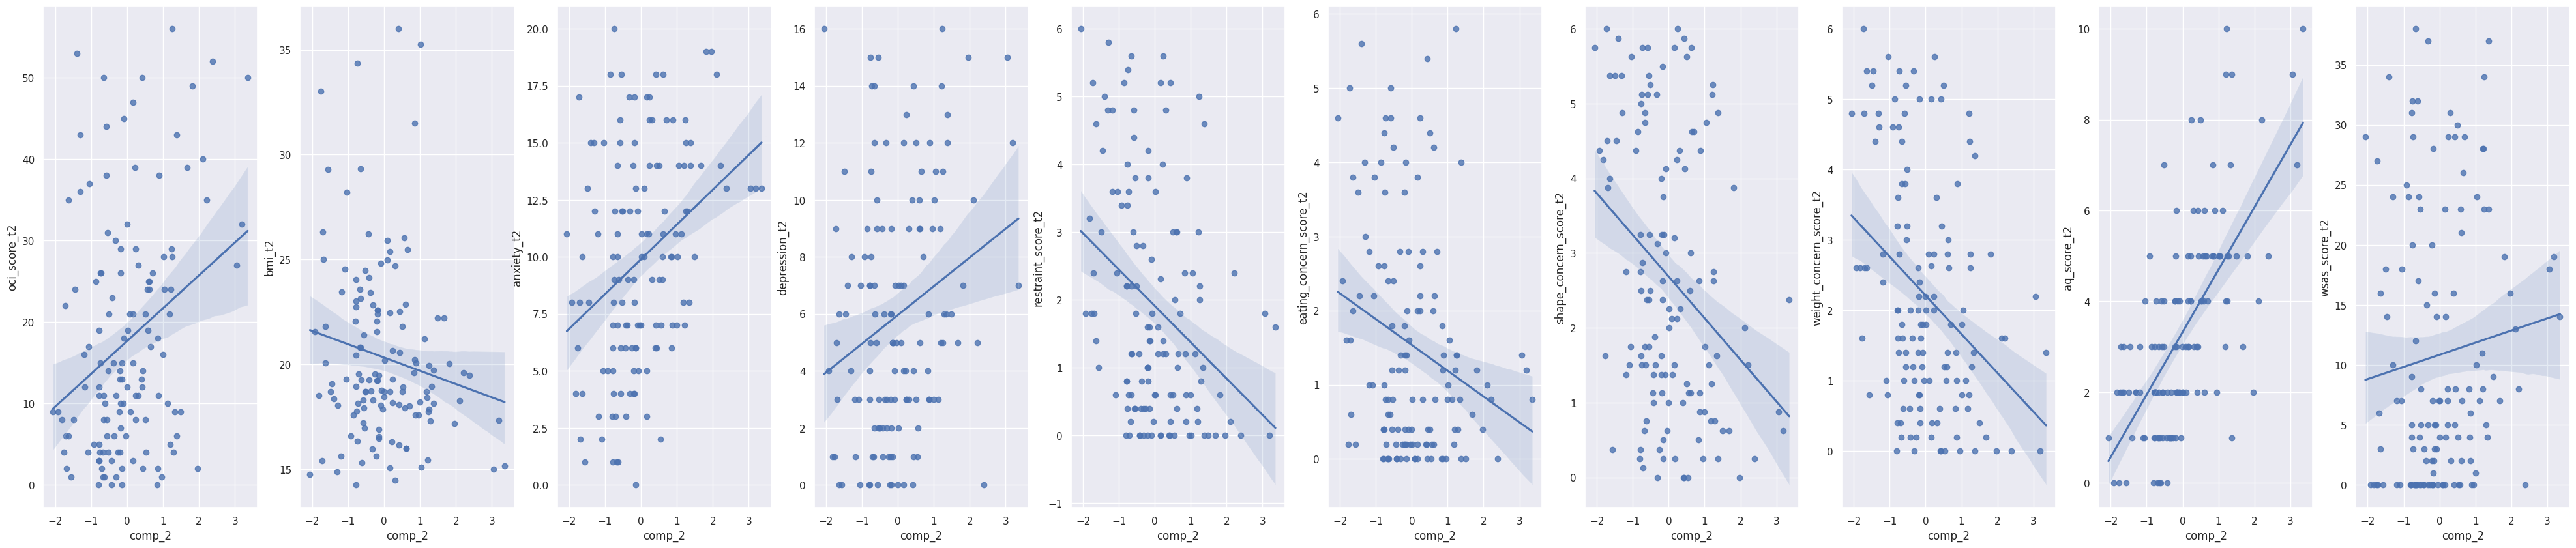

In [54]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_2',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_2'])

{'oci_score_t2': 0.2667705879473775, 'bmi_t2': 0.8639446049077972, 'anxiety_t2': 0.0935237029154419, 'depression_t2': 0.12410663466365231, 'restraint_score_t2': -0.04409914499906059, 'eating_concern_score_t2': -0.080597160677778, 'shape_concern_score_t2': 0.10226258375796778, 'weight_concern_score_t2': 0.14808811029407018, 'aq_score_t2': 0.09066271479799035, 'wsas_score_t2': -0.13622253910299628}


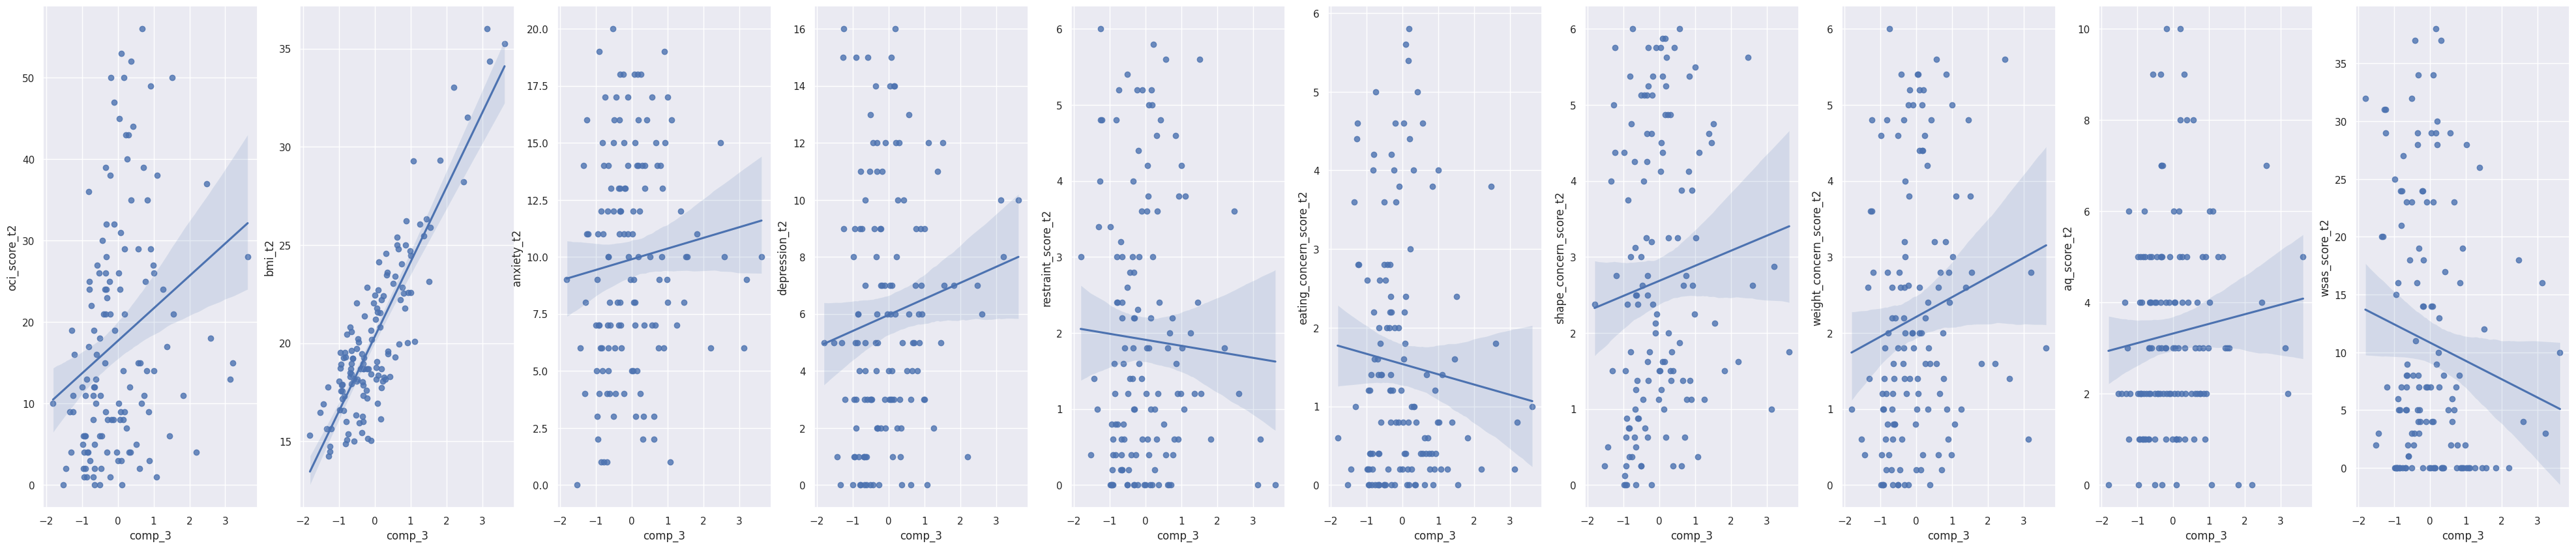

In [55]:
fig, ax = plt.subplots(1, 10,figsize=(50, 10))

for index, measure in enumerate(measures_t2):
    sns.regplot(y=measure, x='comp_3',data=t2_df_seg, ax=ax[index])
print(correlations_t2['comp_3'])

## Save dataframes to sql database

In [56]:
pca_t1 = t1_df_seg[['G_Number', 'comp_1', 'comp_2', 'comp_3']]
pca_t2 = t2_df_seg[['B_Number', 'comp_1', 'comp_2', 'comp_3']]
pca_combined_data_set = pd.concat([pca_t1.rename(columns={'comp_1': 'comp_1_t1', 'comp_2': 'comp_2_t1', 'comp_3': 'comp_3_t1'}), pca_t2.rename(columns={'comp_1': 'comp_1_t2', 'comp_2': 'comp_2_t2', 'comp_3': 'comp_3_t2'})], axis=1)
pca_combined_data_set['group'] = pca_df['group']

In [57]:
pca_combined_data_set

,G_Number,comp_1_t1,comp_2_t1,comp_3_t1,B_Number,comp_1_t2,comp_2_t2,comp_3_t2,group
0,G1038,-3.397712,-0.039728,0.044067,B1002,-2.751847,-1.763316,2.199746,HC
1,G1010,-3.759757,-0.312506,0.406467,B1003,-3.441539,-0.316748,-0.210088,HC
2,G1014,-3.532270,-0.211892,0.493511,B1004,-1.389329,0.311159,0.983941,HC
3,G1056,-2.459692,-0.062705,-0.095992,B1006,-1.050591,1.116984,0.019420,HC
4,G1023,-1.476319,-0.129427,1.175674,B1007,-1.181176,-0.783917,0.744101,HC
...,...,...,...,...,...,...,...,...,...
129,G2141,2.462581,-0.667664,-0.436650,B2091,2.025310,1.042486,-0.784687,AN
130,G2138,-1.634660,-0.686854,-1.347601,B2092,0.157375,-0.139806,-0.360662,AN
131,G2140,2.637032,-2.079384,-1.025924,B2093,3.998414,-2.064403,-1.245633,AN
132,G2105,2.295672,-0.339904,0.279827,B2094,4.474773,-1.406758,0.090732,AN


In [58]:
connector = connect_to_database('BEACON')
pca_t1.to_sql('pca_t1', connector)
pca_t2.to_sql('pca_t2', connector)
pca_combined_data_set.to_sql('pca_df', connector)
pca_df.to_sql('imputated_combined_data',connector )

-1